In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import time
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import classification_report

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

from prettytable import PrettyTable

In [2]:
# collab drive mount
from google.colab import drive
drive.mount('/content/drive')

# loading previos feature extraction dataset
X_train = pd.read_csv("/content/drive/MyDrive/collab_data/Quora/X_train.csv")
X_test = pd.read_csv("/content/drive/MyDrive/collab_data/Quora/X_test.csv")
y_train = pd.read_csv("/content/drive/MyDrive/collab_data/Quora/y_train.csv")
y_test = pd.read_csv("/content/drive/MyDrive/collab_data/Quora/y_test.csv")


Mounted at /content/drive


In [3]:
# check 
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_train: ",y_test.shape)

X_train:  (1919, 220)
X_test:  (480, 220)
y_train:  (1919, 1)
y_train:  (480, 1)


In [4]:
X_train.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919 entries, 0 to 1918
Data columns (total 220 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1919 non-null   int64  
 1   qid1                  1919 non-null   int64  
 2   qid2                  1919 non-null   int64  
 3   is_duplicate          1919 non-null   int64  
 4   freq_qid1             1919 non-null   int64  
 5   freq_qid2             1919 non-null   int64  
 6   lenq1                 1919 non-null   int64  
 7   lenq2                 1919 non-null   int64  
 8   q1_n_words            1919 non-null   int64  
 9   q2_n_words            1919 non-null   int64  
 10  word_Common           1919 non-null   int64  
 11  word_Total            1919 non-null   int64  
 12  word_share            1919 non-null   float64
 13  freq_q1+q2            1919 non-null   int64  
 14  freq_q1-q2            1919 non-null   int64  
 15  cwc_min             

In [5]:
# drop unwanted columns from X_train

X_train.drop(['Clean_Q1'], axis=1, inplace=True)
X_train.drop(['Clean_Q2'], axis=1, inplace=True)
X_train.drop(['qid1'], axis=1, inplace=True)
X_train.drop(['qid2'], axis=1, inplace=True)
X_train.drop(['id'], axis=1, inplace=True)
X_train.drop(['is_duplicate'], axis=1, inplace=True)
X_train.drop(X_train.index[0], inplace=True)


In [6]:
# drop unwanted columns from X_test

X_test.drop(['Clean_Q1'], axis=1, inplace=True)
X_test.drop(['Clean_Q2'], axis=1, inplace=True)
X_test.drop(['qid1'], axis=1, inplace=True)
X_test.drop(['qid2'], axis=1, inplace=True)
X_test.drop(['id'], axis=1, inplace=True)
X_test.drop(['is_duplicate'], axis=1, inplace=True)
X_test.drop(X_test.index[0], inplace=True)


In [7]:
# drop unwanted columns from y_train & y_test

y_train.drop(y_train.index[0], inplace=True)
y_test.drop(y_test.index[0], inplace=True)

In [8]:
X_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1918 entries, 1 to 1918
Data columns (total 214 columns):
 #   Column                Dtype  
---  ------                -----  
 0   freq_qid1             int64  
 1   freq_qid2             int64  
 2   lenq1                 int64  
 3   lenq2                 int64  
 4   q1_n_words            int64  
 5   q2_n_words            int64  
 6   word_Common           int64  
 7   word_Total            int64  
 8   word_share            float64
 9   freq_q1+q2            int64  
 10  freq_q1-q2            int64  
 11  cwc_min               float64
 12  cwc_max               float64
 13  csc_min               float64
 14  csc_max               float64
 15  ctc_min               float64
 16  ctc_max               float64
 17  first_word_eq         float64
 18  last_word_eq          float64
 19  abs_len_diff          float64
 20  mean_len              float64
 21  longest_substr_ratio  float64
 22  0_x                   float64
 23  1_x         

In [9]:
# converting X_train and X_test into numeric 

X_train_cols = list(X_train.columns)
X_test_cols = list(X_test.columns)

X_train[X_train_cols] = X_train[X_train_cols].apply(pd.to_numeric, errors='coerce')
X_test[X_test_cols] = X_test[X_test_cols].apply(pd.to_numeric, errors='coerce')

In [10]:

# check 
print("X_train: ",X_train.shape)
print("X_test: ",X_test.shape)
print("y_train: ",y_train.shape)
print("y_train: ",y_test.shape)

X_train:  (1918, 214)
X_test:  (479, 214)
y_train:  (1918, 1)
y_train:  (479, 1)


In [ ]:

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8927419349407313


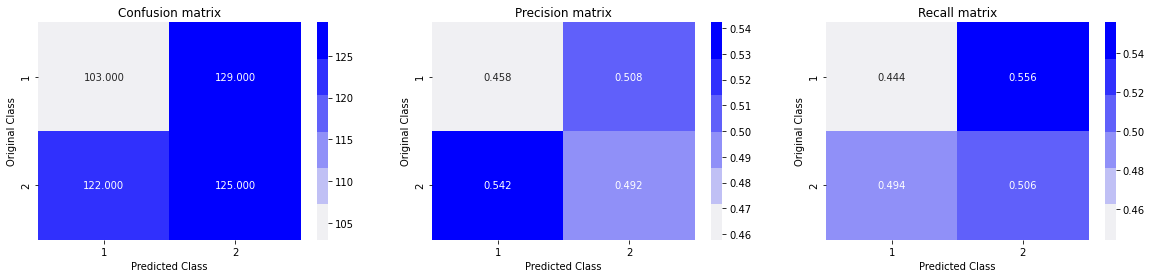

In [ ]:
# random model : to compute max thereshold for 

test_len = len(y_test)
train_len = len(y_train)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# 1.0 Logistic Regression (SDG)

For values of alpha =  1e-05 The log loss is: 0.6934009633376309
For values of alpha =  0.0001 The log loss is: 0.6934009633376309
For values of alpha =  0.001 The log loss is: 0.6034088717082293
For values of alpha =  0.01 The log loss is: 0.6175891256522595
For values of alpha =  0.1 The log loss is: 0.6051521483399566
For values of alpha =  1 The log loss is: 0.6089504372557002
For values of alpha =  10 The log loss is: 0.6491886317884153
----------------------------------------------------------------------------------------------------
optimal alpha index:  2
optimal alpha log loss:  0.6034088717082293
----------------------------------------------------------------------------------------------------


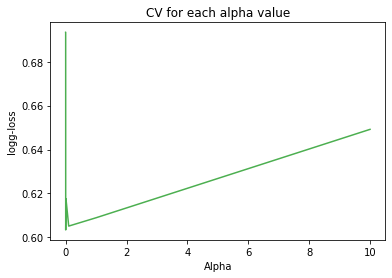

----------------------------------------------------------------------------------------------------
CPU times: user 6.41 s, sys: 3.35 s, total: 9.76 s
Wall time: 6.02 s


In [ ]:
%%time
alpha = [10 ** x for x in range(-5, 2)] # learning rate , hyper parameter
#print(alpha)

log_error = []
for i in alpha:
  clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=4, learning_rate='optimal')  #loss = 'log' = logistic regression with L2 
  clf.fit(X_train, y_train)
  # calibrate, because we are using log loss, logg-loss works with probability , not actual predicted y value 
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(X_train, y_train)
  predict_y = sig_clf.predict_proba(X_test)
  log_error.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
  print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

print("-"*100)
# find index of min log-loss error value 
optimal_alpha_index = np.argmin(log_error)
print("optimal alpha index: ", optimal_alpha_index)
# find min log-loss error value 
print("optimal alpha log loss: ", min(log_error))
print("-"*100)

plt.plot(alpha, log_error, c = '#4CAF50')
plt.title("CV for each alpha value")
plt.xlabel("Alpha")
plt.ylabel("logg-loss")
plt.show()
print("-"*100)

In [ ]:
# train with optoimal alpha value 
clf = SGDClassifier(alpha=alpha[optimal_alpha_index], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y = sig_clf.predict_proba(X_train)

print('For values of best alpha = ', alpha[optimal_alpha_index], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[optimal_alpha_index], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points (TEST) :", len(predicted_y))

For values of best alpha =  0.001 The train log loss is: 0.5519140406614621
For values of best alpha =  0.001 The test log loss is: 0.6134690806141911
Total number of data points (TEST) : 479


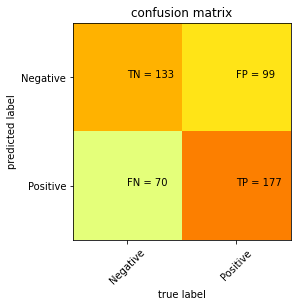

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, predicted_y)

plt.clf()
plt.imshow(cm, cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('confusion matrix')
plt.ylabel('predicted label')
plt.xlabel('true label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [ ]:
print("_" * 101)
print("Classification Report: \n")
print(classification_report(y_test, predicted_y))
print("_" * 101)

_____________________________________________________________________________________________________
Classification Report: 

              precision    recall  f1-score   support

           0       0.66      0.57      0.61       232
           1       0.64      0.72      0.68       247

    accuracy                           0.65       479
   macro avg       0.65      0.64      0.64       479
weighted avg       0.65      0.65      0.65       479

_____________________________________________________________________________________________________


# 2.0 SVM hyperparameter tuning (SGD)

For values of alpha =  1e-05 The log loss is: 0.6934009633376309
For values of alpha =  0.0001 The log loss is: 0.6934009633376309
For values of alpha =  0.001 The log loss is: 0.6934009633376309
For values of alpha =  0.01 The log loss is: 0.6469082257866012
For values of alpha =  0.1 The log loss is: 0.6824821954758409
For values of alpha =  1 The log loss is: 0.6934009633376309
For values of alpha =  10 The log loss is: 0.6903445368554381
----------------------------------------------------------------------------------------------------
optimal alpha index:  3
optimal alpha log loss:  0.6469082257866012
----------------------------------------------------------------------------------------------------


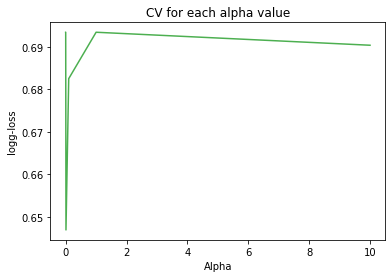

----------------------------------------------------------------------------------------------------
CPU times: user 1min, sys: 3.56 s, total: 1min 4s
Wall time: 1min


In [ ]:
%%time
alpha = [10 ** x for x in range(-5, 2)] # learning rate , hyper parameter
#print(alpha)

log_error = []
for i in alpha:
  clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=10, learning_rate='optimal')  #loss = 'hinge' = SVM with L1 
  clf.fit(X_train, y_train)
  # calibrate, because we are using log loss, logg-loss works with probability , not actual predicted y value 
  sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
  sig_clf.fit(X_train, y_train)
  predict_y = sig_clf.predict_proba(X_test)
  log_error.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
  print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

print("-"*100)
# find index of min log-loss error value 
optimal_alpha_index = np.argmin(log_error)
print("optimal alpha index: ", optimal_alpha_index)
# find min log-loss error value 
print("optimal alpha log loss: ", min(log_error))
print("-"*100)

plt.plot(alpha, log_error, c = '#4CAF50')
plt.title("CV for each alpha value")
plt.xlabel("Alpha")
plt.ylabel("logg-loss")
plt.show()
print("-"*100)

In [ ]:
# train with optoimal alpha value 
clf = SGDClassifier(alpha=alpha[optimal_alpha_index], penalty='l1', loss='hinge', random_state=10)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y = sig_clf.predict_proba(X_train)

print('For values of best alpha = ', alpha[optimal_alpha_index], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[optimal_alpha_index], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points (TEST) :", len(predicted_y))

For values of best alpha =  0.01 The train log loss is: 0.6134933701567161
For values of best alpha =  0.01 The test log loss is: 0.6469082257866012
Total number of data points (TEST) : 479


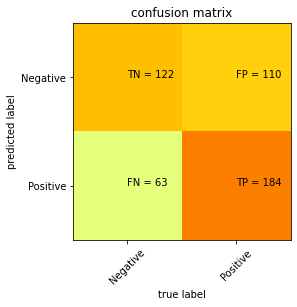

In [ ]:
# confusion matrix
cm = confusion_matrix(y_test, predicted_y)

plt.clf()
plt.imshow(cm, cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('confusion matrix')
plt.ylabel('predicted label')
plt.xlabel('true label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [ ]:
print("_" * 101)
print("Classification Report: \n")
print(classification_report(y_test, predicted_y))
print("_" * 101)

_____________________________________________________________________________________________________
Classification Report: 

              precision    recall  f1-score   support

           0       0.66      0.53      0.59       232
           1       0.63      0.74      0.68       247

    accuracy                           0.64       479
   macro avg       0.64      0.64      0.63       479
weighted avg       0.64      0.64      0.63       479

_____________________________________________________________________________________________________


#3.0 XG Boost





In [12]:
# without hyperparameter (random search)
import xgboost as xgb

params = {}
params['objective'] = 'binary:logistic' 
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)


[0]	train-logloss:0.684617	valid-logloss:0.685623
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.61505	valid-logloss:0.623918
[20]	train-logloss:0.564119	valid-logloss:0.578998
[30]	train-logloss:0.525103	valid-logloss:0.545653
[40]	train-logloss:0.495017	valid-logloss:0.519375
[50]	train-logloss:0.471557	valid-logloss:0.499041
[60]	train-logloss:0.45223	valid-logloss:0.4827
[70]	train-logloss:0.436083	valid-logloss:0.469926
[80]	train-logloss:0.422339	valid-logloss:0.45958
[90]	train-logloss:0.410791	valid-logloss:0.451307
[100]	train-logloss:0.400608	valid-logloss:0.444782
[110]	train-logloss:0.391243	valid-logloss:0.440304
[120]	train-logloss:0.38197	valid-logloss:0.43579
[130]	train-logloss:0.373842	valid-logloss:0.431948
[140]	train-logloss:0.366317	valid-logloss:0.429017
[150]	train-logloss:0.358567	valid-logloss:0.427699
[160]	train-logloss:0.352159	valid-

In [ ]:
# with HYPER PARAMETER (random search)

#%%time
from sklearn.model_selection import RandomizedSearchCV
 
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

clf = xgb.XGBClassifier()

parameters = {
     "eta"    : [0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 2, 4, 8, 10, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
     "ecal_metric": 'logloss',
     'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3]
     }

rs_clif = RandomizedSearchCV(clf,param_distributions=parameters, n_iter=5, n_jobs=-1, scoring='neg_log_loss', verbose=4, cv=5)

rs_clif.fit(X_train, y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   22.1s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                  

In [ ]:
rs_clif.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, ecal_metric='l',
              eta=0.25, gamma=0.4, learning_rate=0.1, max_delta_step=0,
              max_depth=2, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
rs_clif.best_params_

{'colsample_bytree': 0.4,
 'ecal_metric': 'g',
 'eta': 0.05,
 'gamma': 0.1,
 'learning_rate': 0.01,
 'max_depth': 15,
 'min_child_weight': 3}

In [13]:
# XGB with best params 

params = {'colsample_bytree': 0.4,
 'ecal_metric': 'g',
 'eta': 0.05,
 'gamma': 0.1,
 'learning_rate': 0.01,
 'max_depth': 15,
 'min_child_weight': 3}

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)


[0]	train-rmse:0.495763	valid-rmse:0.498061
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 20 rounds.
[10]	train-rmse:0.456278	valid-rmse:0.48192
[20]	train-rmse:0.420226	valid-rmse:0.468013
[30]	train-rmse:0.386785	valid-rmse:0.45604
[40]	train-rmse:0.356931	valid-rmse:0.445749
[50]	train-rmse:0.329353	valid-rmse:0.437071
[60]	train-rmse:0.303836	valid-rmse:0.429467
[70]	train-rmse:0.280429	valid-rmse:0.422983
[80]	train-rmse:0.259165	valid-rmse:0.417581
[90]	train-rmse:0.239075	valid-rmse:0.41217
[100]	train-rmse:0.221129	valid-rmse:0.407985
[110]	train-rmse:0.204777	valid-rmse:0.405124
[120]	train-rmse:0.189618	valid-rmse:0.402434
[130]	train-rmse:0.176133	valid-rmse:0.400008
[140]	train-rmse:0.163813	valid-rmse:0.398122
[150]	train-rmse:0.152101	valid-rmse:0.396065
[160]	train-rmse:0.141747	valid-rmse:0.39464
[170]	train-rmse:0.132251	valid-rmse:0.393309
[180]	train-rmse:0.12367	valid-rmse:0.3919

Total number of data points : 479


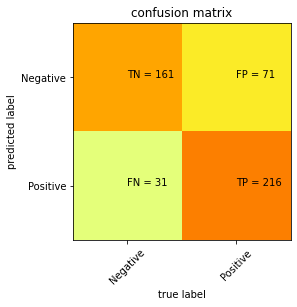

In [15]:
xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))

# confusion matrix
cm = confusion_matrix(y_test, predicted_y)

plt.clf()
plt.imshow(cm, cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('confusion matrix')
plt.ylabel('predicted label')
plt.xlabel('true label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [16]:
print("_" * 101)
print("Classification Report: \n")
print(classification_report(y_test, predicted_y))
print("_" * 101)

_____________________________________________________________________________________________________
Classification Report: 

              precision    recall  f1-score   support

           0       0.84      0.69      0.76       232
           1       0.75      0.87      0.81       247

    accuracy                           0.79       479
   macro avg       0.80      0.78      0.78       479
weighted avg       0.79      0.79      0.78       479

_____________________________________________________________________________________________________


## XGboost model performing better!